In [1]:
%reload_ext autoreload
%autoreload 2
import cudf_tools as ct
import cudf_tools.cudf_flavor as cf
import cudf_tools.unit_methods
from kdephys.xr import xr_flavor_da, xr_flavor_ds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cudf_tools.unit_analysis import *
from kdephys.plot.main import *
from kdephys.plot.units import *
from acr.stim import get_pulse_train_times, get_total_spike_rate
from acr.units import get_cluster_notes, get_fr_by_cluster, get_fr_suppression_by_cluster
plt.style.use('fast')
plt.style.use('/home/kdriessen/github_t2/kdephys/kdephys/plot/acr_plots.mplstyle')

In [2]:
subject = 'ACR_18'
exp = 'swi'
stores = ['NNXr', 'NNXo']
sort_ids = [f'{exp}-{store}' for store in stores]
recordings = acr.info_pipeline.get_exp_recs(subject, exp)

In [4]:
df = load_spike_cudf(subject, sort_ids, refresh_state=False, drop=['exp', 'amp', 'state']) # load spike dataframes as cudf dataframes

added attributes
subject attribute is: ACR_18


In [5]:
h = acr.io.load_hypno_full_exp(subject, exp)

In [ ]:
probe = 'NNXr'
t1 = pd.Timestamp(df.prb(probe).datetime.min())
t2 = pd.Timestamp(df.prb(probe).datetime.max())
f = plot_all_clusters(df, probe, t1, t2, window='300s', hypno=h)

In [ ]:
probe = 'NNXo'
t1 = pd.Timestamp(df.prb(probe).datetime.min())
t2 = pd.Timestamp(df.prb(probe).datetime.max())
f = plot_all_clusters(df, probe, t1, t2, window='300s', hypno=h)

# Can we associate firing rate of certain clusters with EMG activation?

In [6]:
emg = acr.io.load_concat_raw_data(subject, recordings, ['EMGr'], select={'channel': 1})
emg = emg.sel(store='EMGr')

In [7]:
emg.data = np.absolute(emg.data-emg.data.mean())

In [8]:
bp = acr.io.load_concat_bandpower(subject, recordings, ['EMGr'], select={'channel': 1, 'store': 'EMGr'})

swi-bl was missing recording and store coordinates, added them
swi was missing recording and store coordinates, added them
swi-post was missing recording and store coordinates, added them


In [9]:
gam = bp.high_gamma

In [10]:
high_mus = gam[gam>np.percentile(gam.data, 95)]

In [12]:
high_mus_times = high_mus[::50].datetime.data

In [ ]:
for t in high_mus_times:
    

<AxesSubplot: >

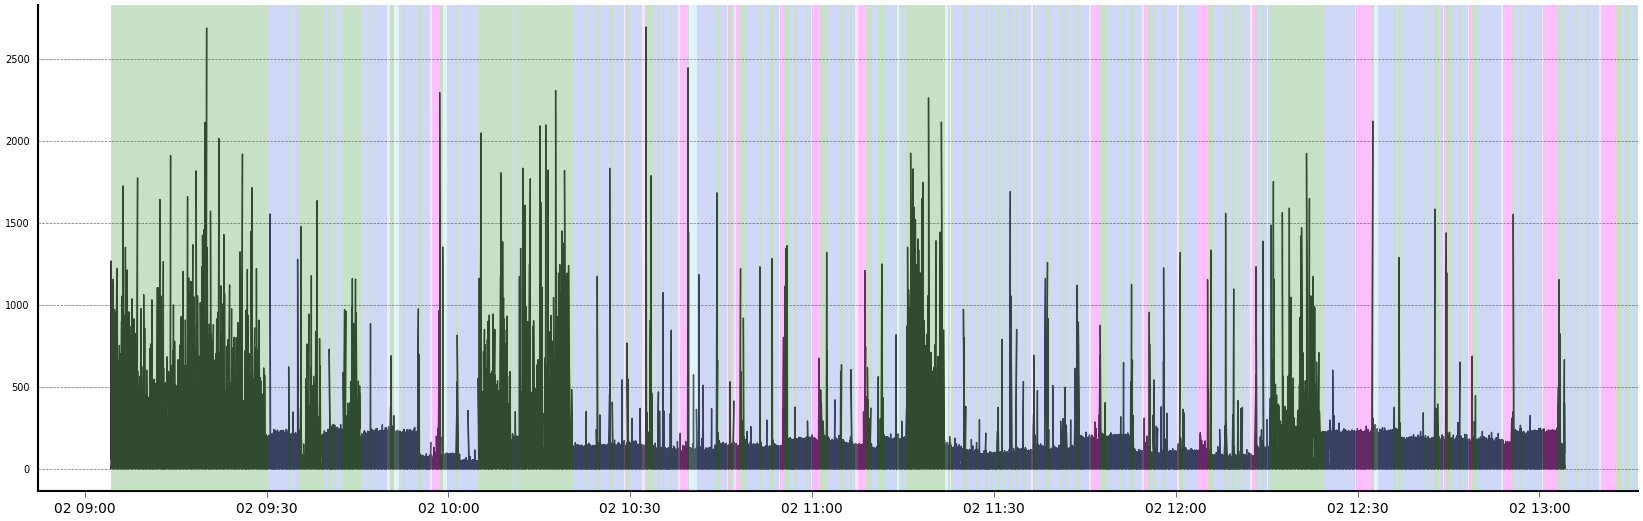

In [25]:
t1 = '2023-01-02T09:04:16.999999000'
t2 = '2023-01-02T13:04:16.999999000'
f, ax = plt.subplots()
ax.plot(emg.ts(t1, t2).datetime, emg.ts(t1, t2))
shade_hypno_for_me(h, ax)

In [27]:
def get_state_fr(df, hyp, t1=None, t2=None, state='NREM'):
    """gets the firing rate for each cluster during a specified state

    Args:
        df (dataframe): spike dataframe
        hyp (dataframe): hypnogram
        t1 (datetime, optional): if not specified, the first 12 hours from the start of the first spike are used. Defaults to None.
        t2 (datetime, optional): if not specified, the first 12 hours from the start of the first spike are used. Defaults to None.
        state (str, optional): state to use. Defaults to 'NREM'.

    Returns:
        frs: dictionary of the firing rates for each cluster in all bouts of the state.
    """
    if t1 is None and t2 is None:
        t1 = df.datetime.min()
        t2 = t1 + pd.Timedelta('12h')
    
    hyp_state = hyp.loc[hyp.state == state]
    hyp_state = hyp_state.loc[hyp_state.end_time < t2]

    frs = {}

    for probe in df.prbs():
        frs[probe] = {}
        probe_df = df.prb(probe)
        for cluster in probe_df.cid_un():
            bout_rates = []
            for bout in hyp_state.itertuples(): # for each bout of the specified state get the firing rate
                start = bout.start_time
                end = bout.end_time
                total_time = bout.duration.total_seconds()
                bout_rate = len(probe_df.cid(cluster).ts(start, end))/total_time
                bout_rates.append(bout_rate)
            frs[probe][cluster] = bout_rates
    return frs

In [28]:
wake_frs = get_state_fr(df, h, state='Wake')

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/kdriessen/miniconda3/envs/acrdev_cuda/include/rmm/mr/device/cuda_memory_resource.hpp